SmartRedis Library@12-18-00:WARNING: Environment variable SR_LOG_FILE is not set. Defaulting to stdout
SmartRedis Library@12-18-00:WARNING: Environment variable SR_LOG_LEVEL is not set. Defaulting to INFO
Cleaning case /home/MMAuser/Projects/research/openfoam/openfoam-smartsim/tutorials/meshMotion/spinningDisk
Allrun.pre in spinningDisk executed with return code: 0
Running blockMesh on /home/MMAuser/Projects/research/openfoam/openfoam-smartsim/tutorials/meshMotion/spinningDisk
Running decomposePar on /home/MMAuser/Projects/research/openfoam/openfoam-smartsim/tutorials/meshMotion/spinningDisk


Restore 0/ from 0.orig/


Allrun.pre in spinningDisk executed with return code: 0
Time step 1
RMSE 0.0035360381339663675, number of epochs 10000


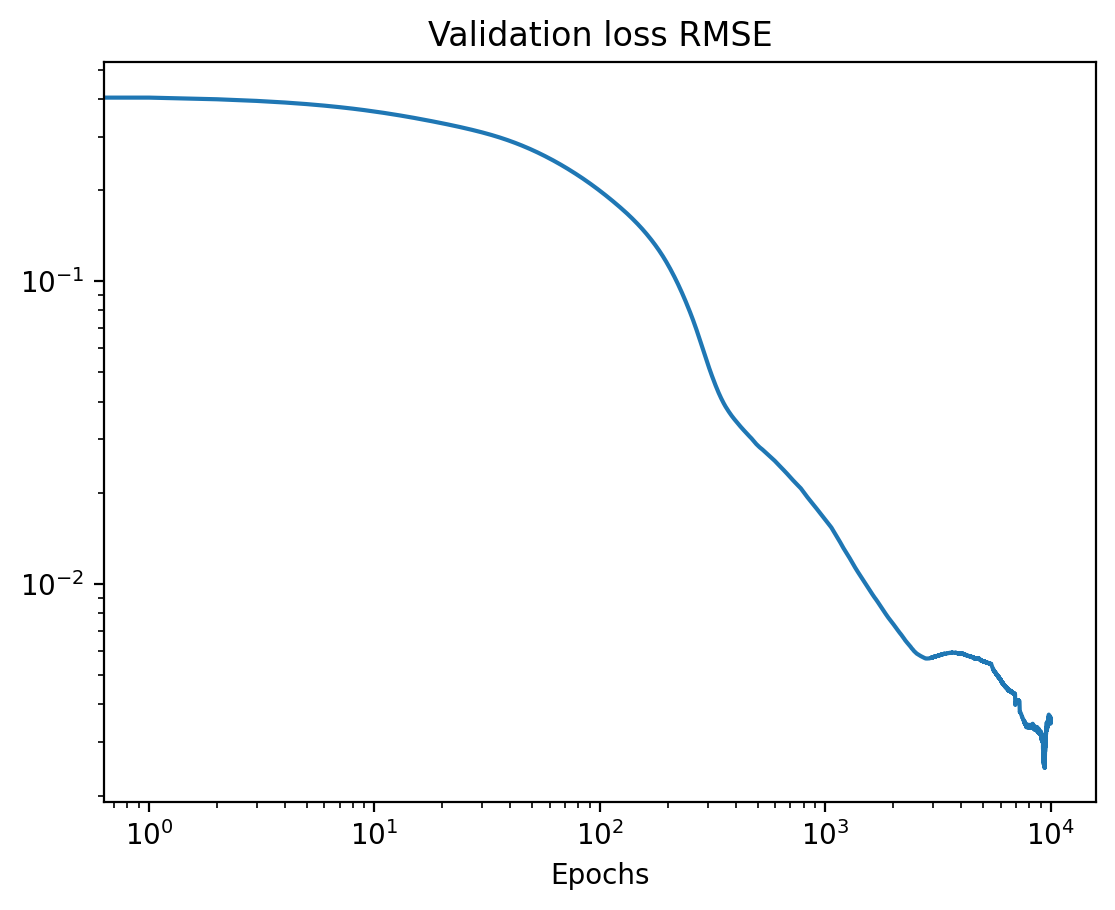

Saving model MLP
Time step 2
RMSE 0.0038884239869881013, number of epochs 10000


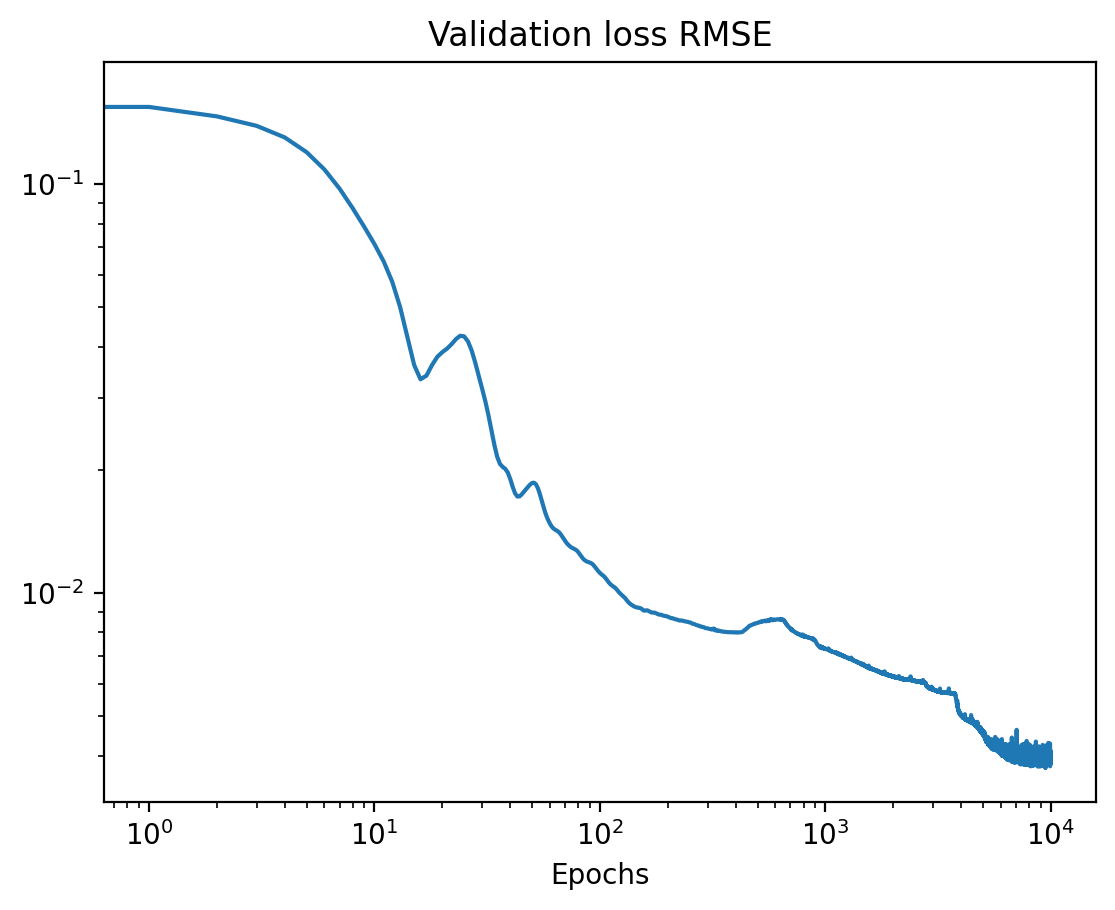

Saving model MLP
Time step 3
RMSE 0.0042332879843025775, number of epochs 10000


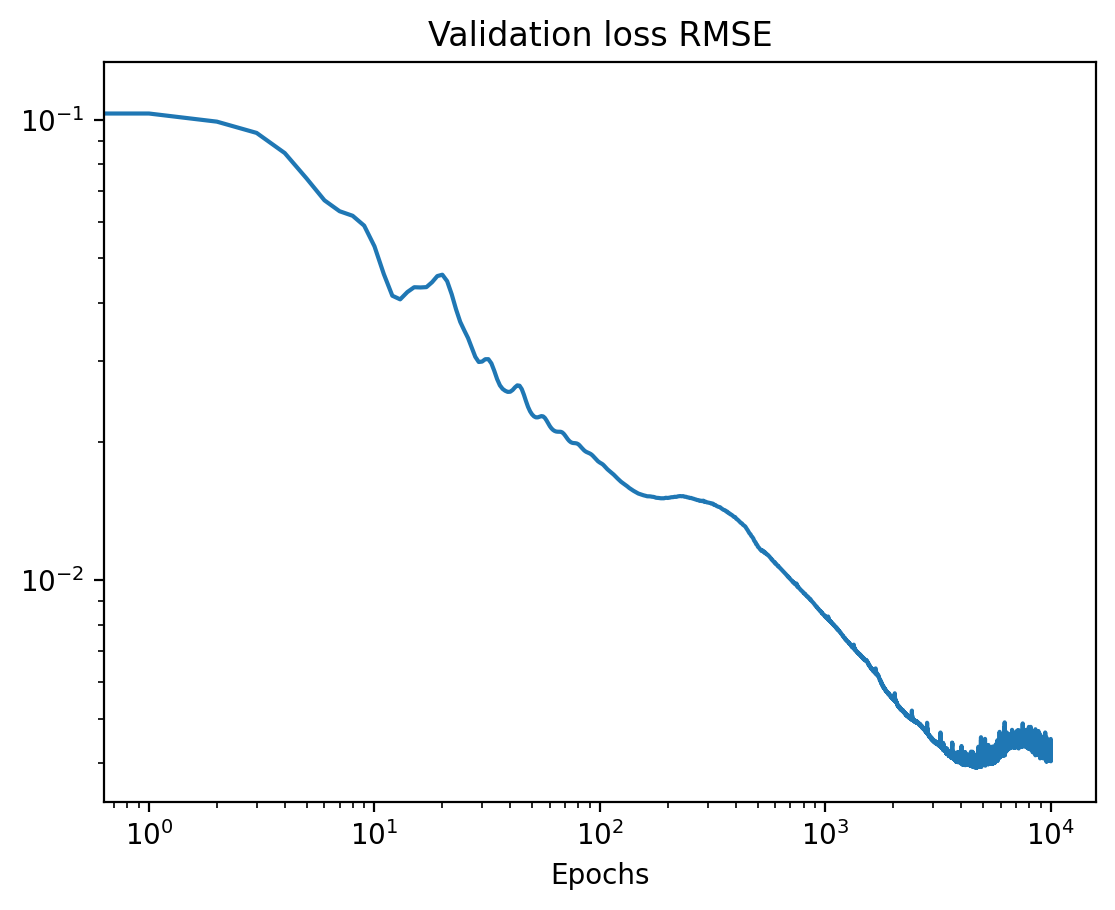

Saving model MLP
Time step 4
RMSE 0.004599838015005501, number of epochs 10000


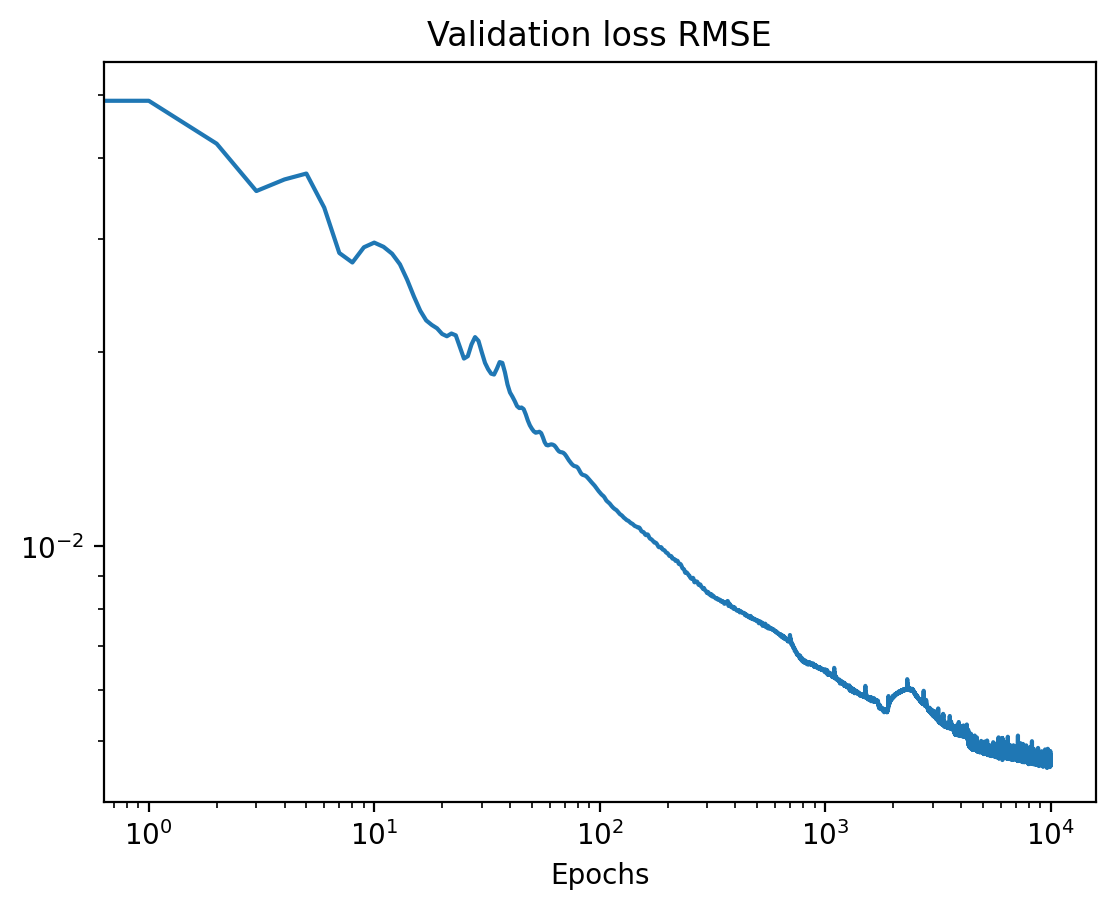

Saving model MLP
Time step 5
RMSE 0.003940328763365609, number of epochs 10000


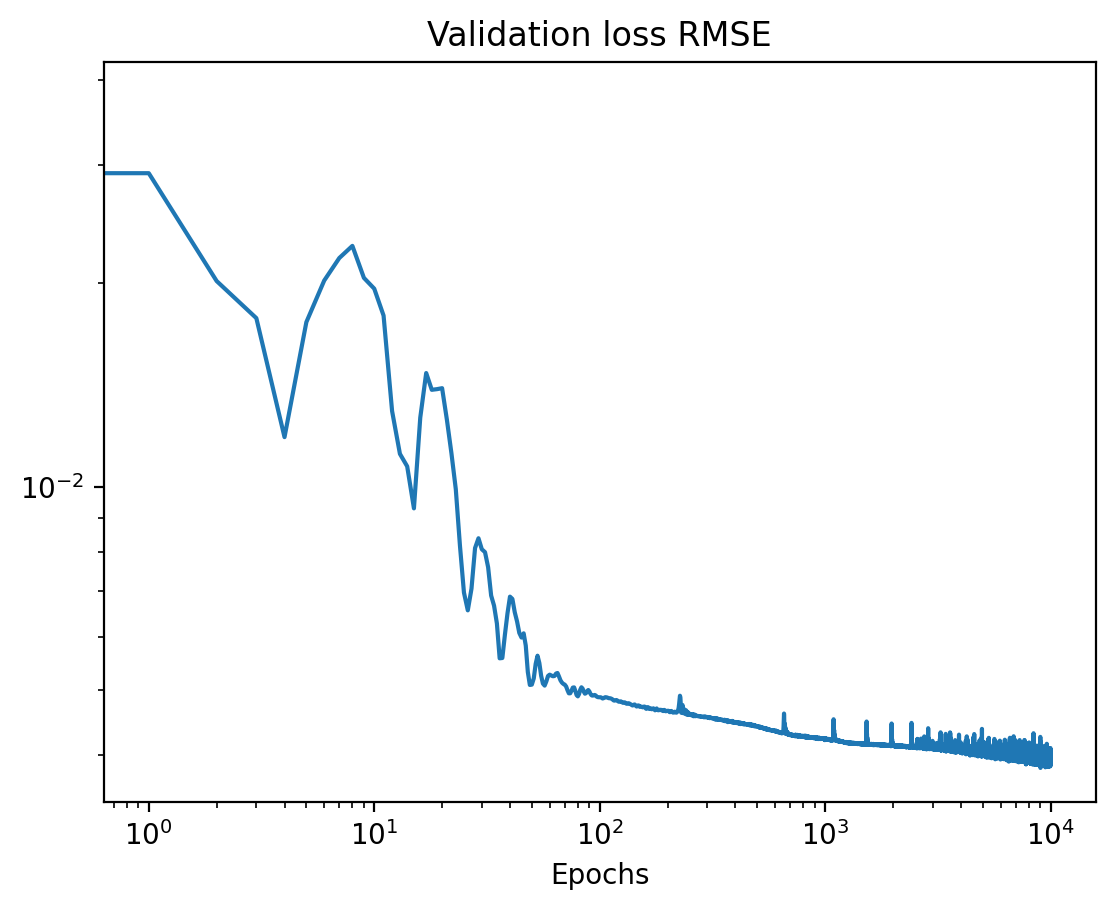

Saving model MLP
Time step 6
RMSE 0.0032255999621369374, number of epochs 10000


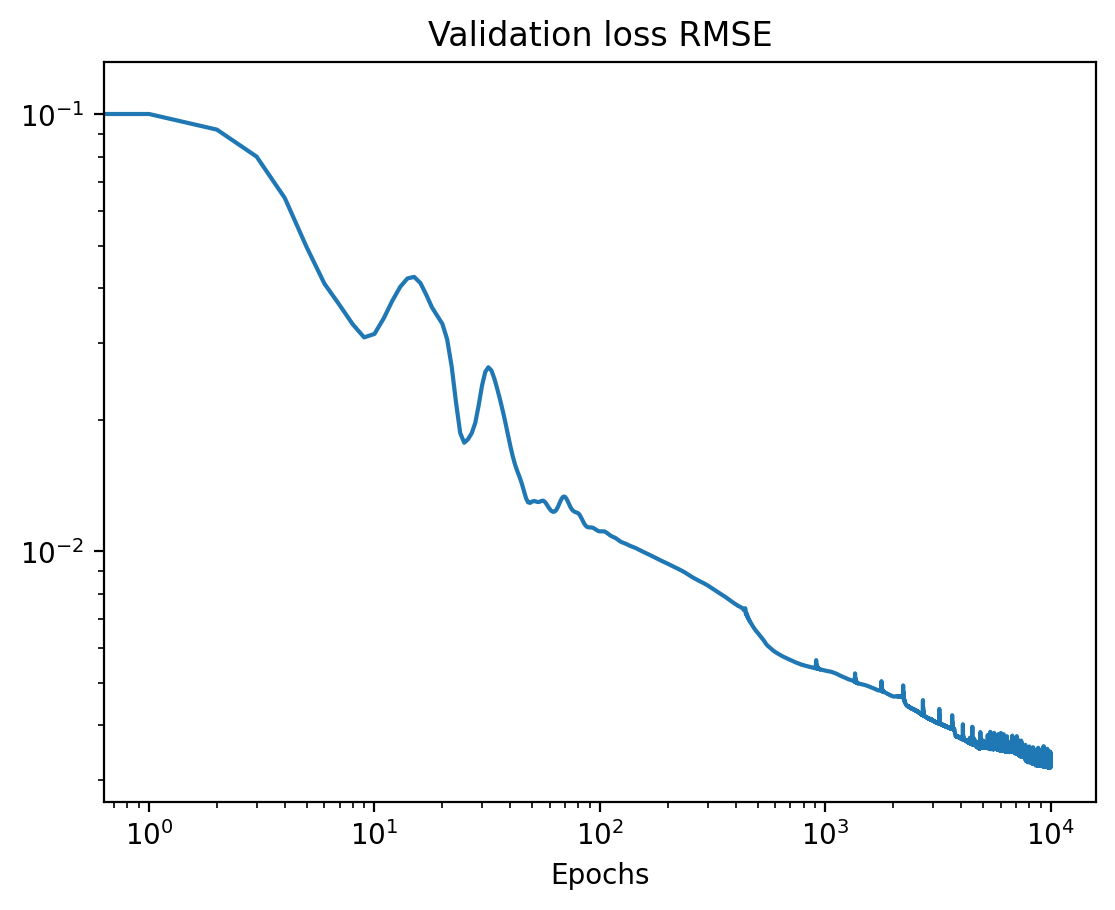

Saving model MLP
Time step 7
RMSE 0.00320273843387027, number of epochs 10000


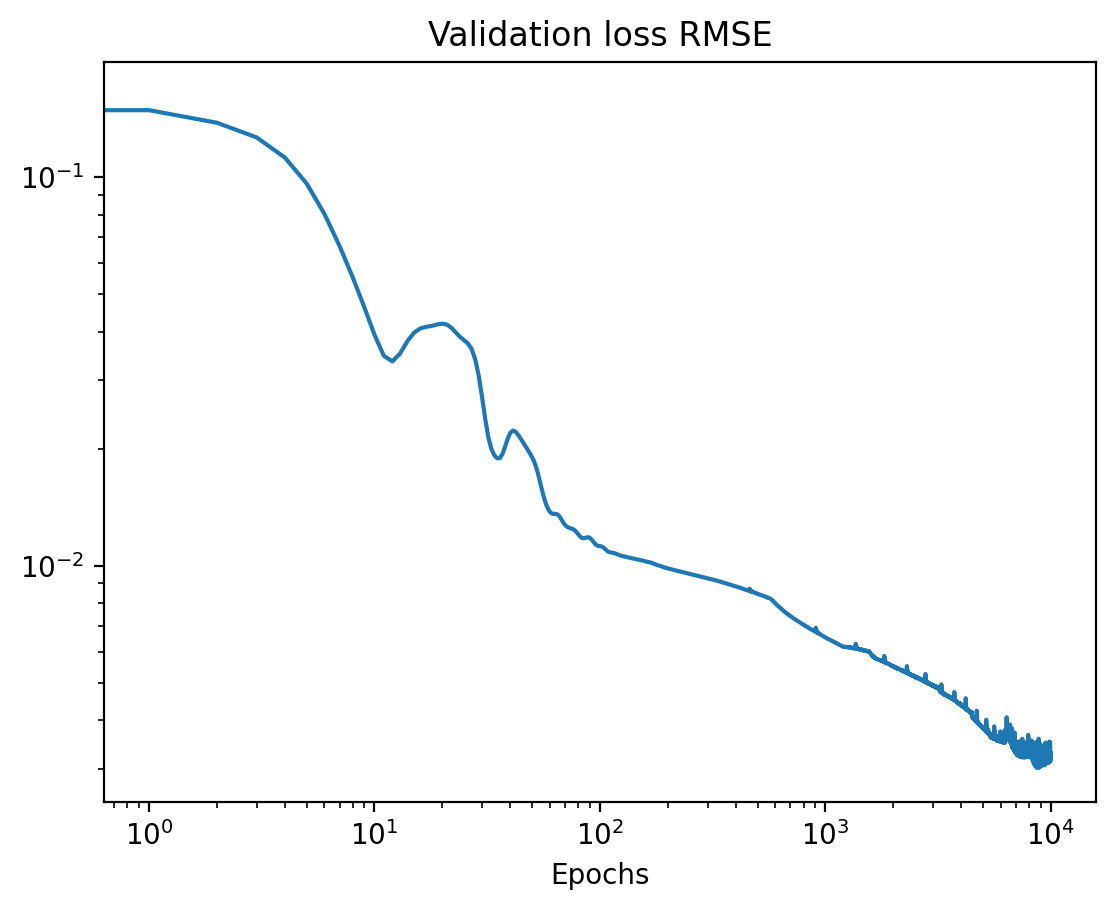

Saving model MLP
Time step 8
RMSE 0.0016501392716090587, number of epochs 10000


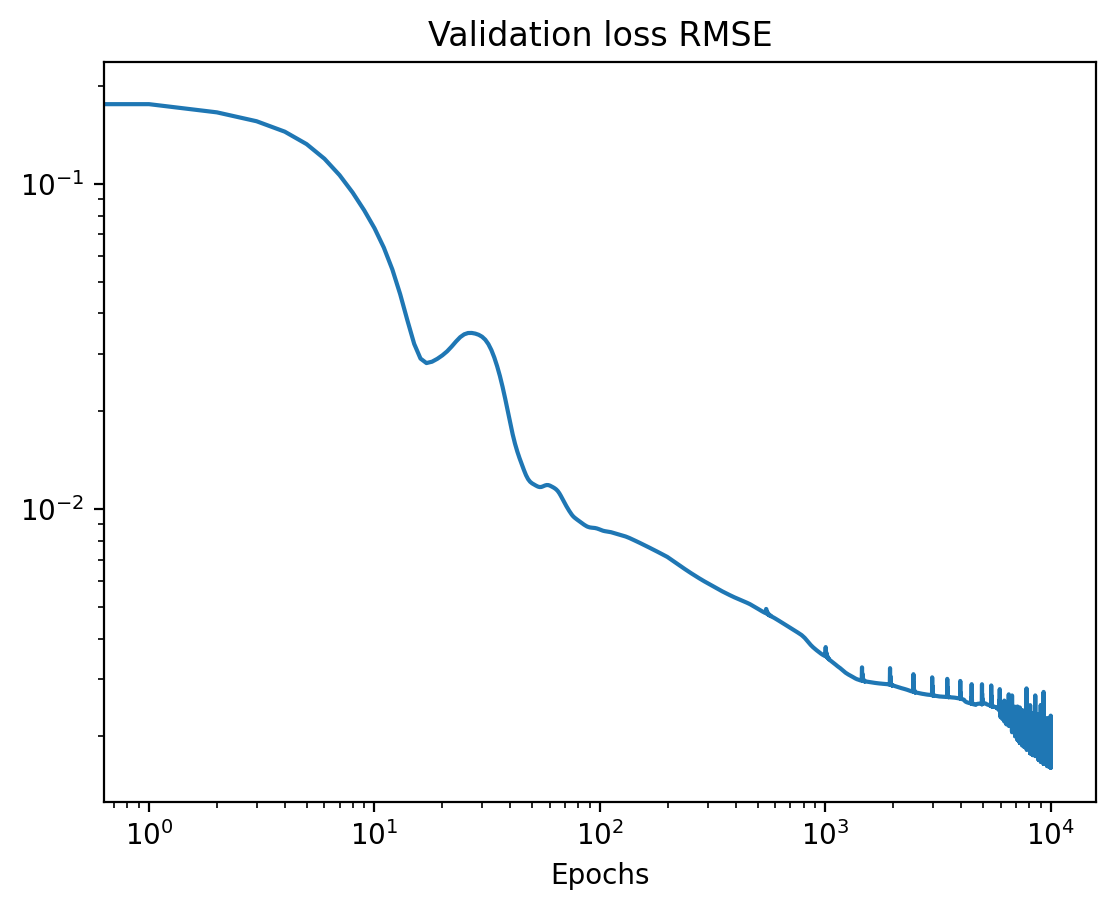

Saving model MLP
Time step 9
RMSE 0.002937948835042848, number of epochs 10000


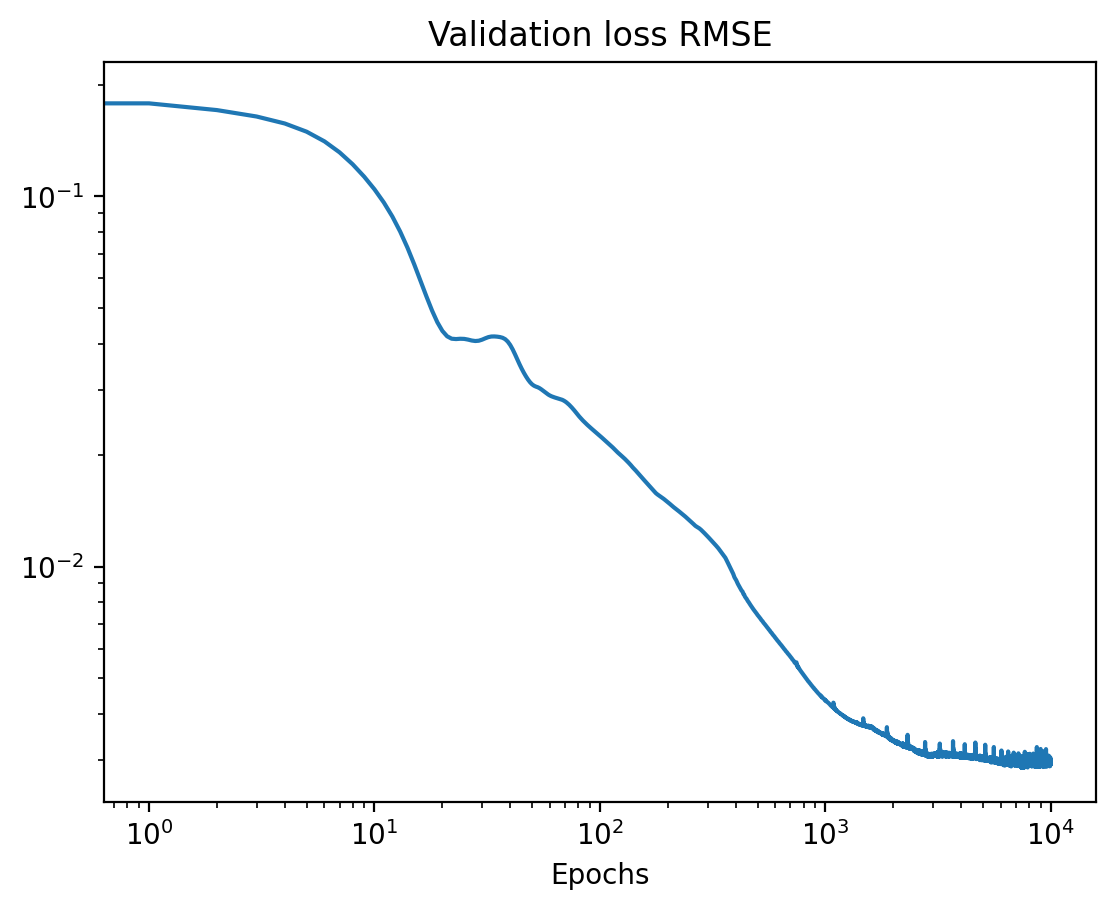

Saving model MLP
Time step 10
RMSE 0.006159249938094956, number of epochs 10000


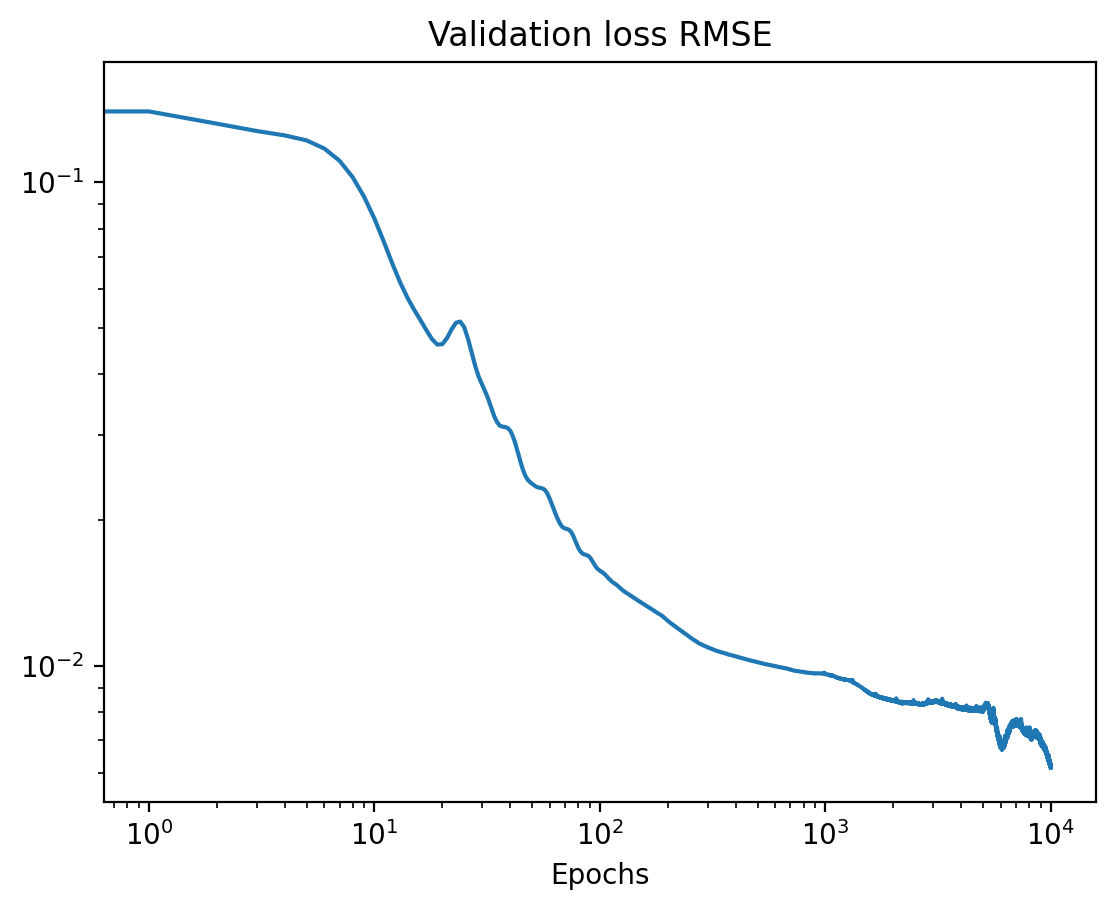

Saving model MLP
Time step 11
RMSE 0.010396215010466713, number of epochs 10000


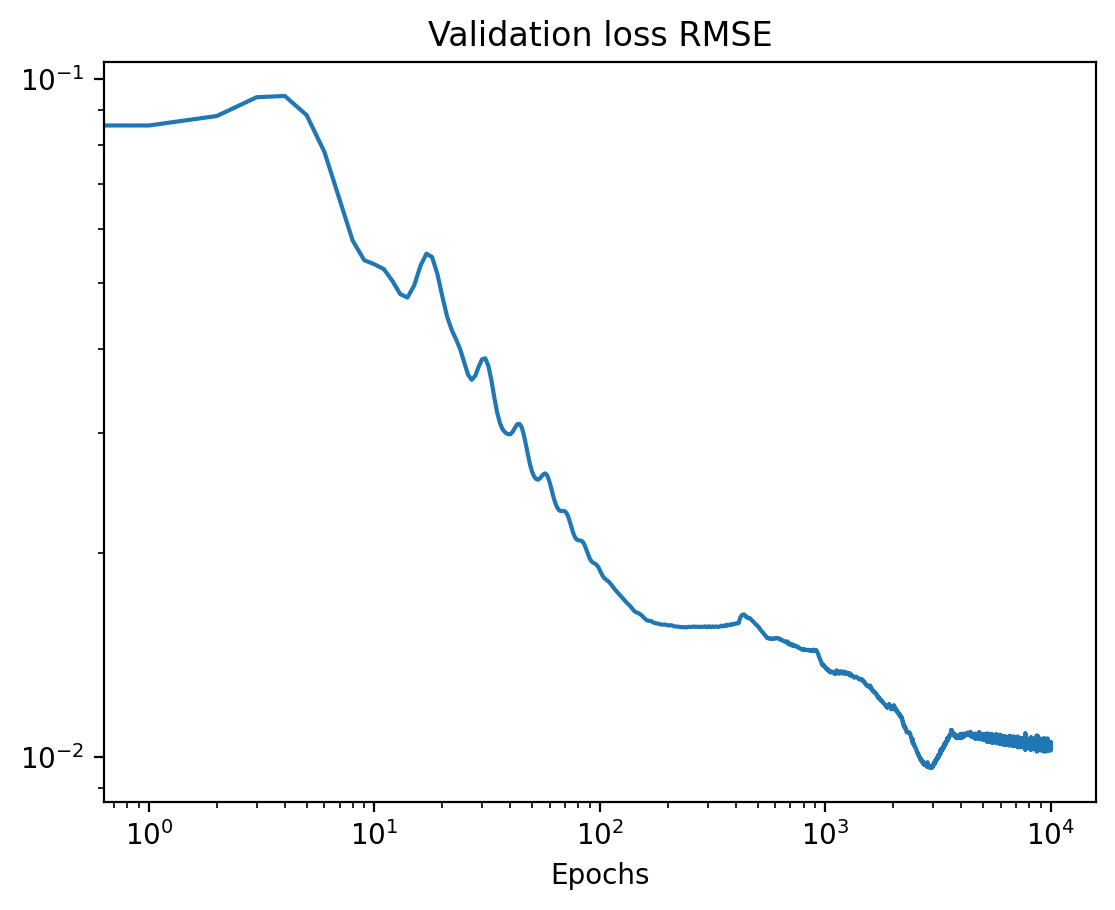

Saving model MLP
Time step 12
RMSE 0.01406747350062789, number of epochs 10000


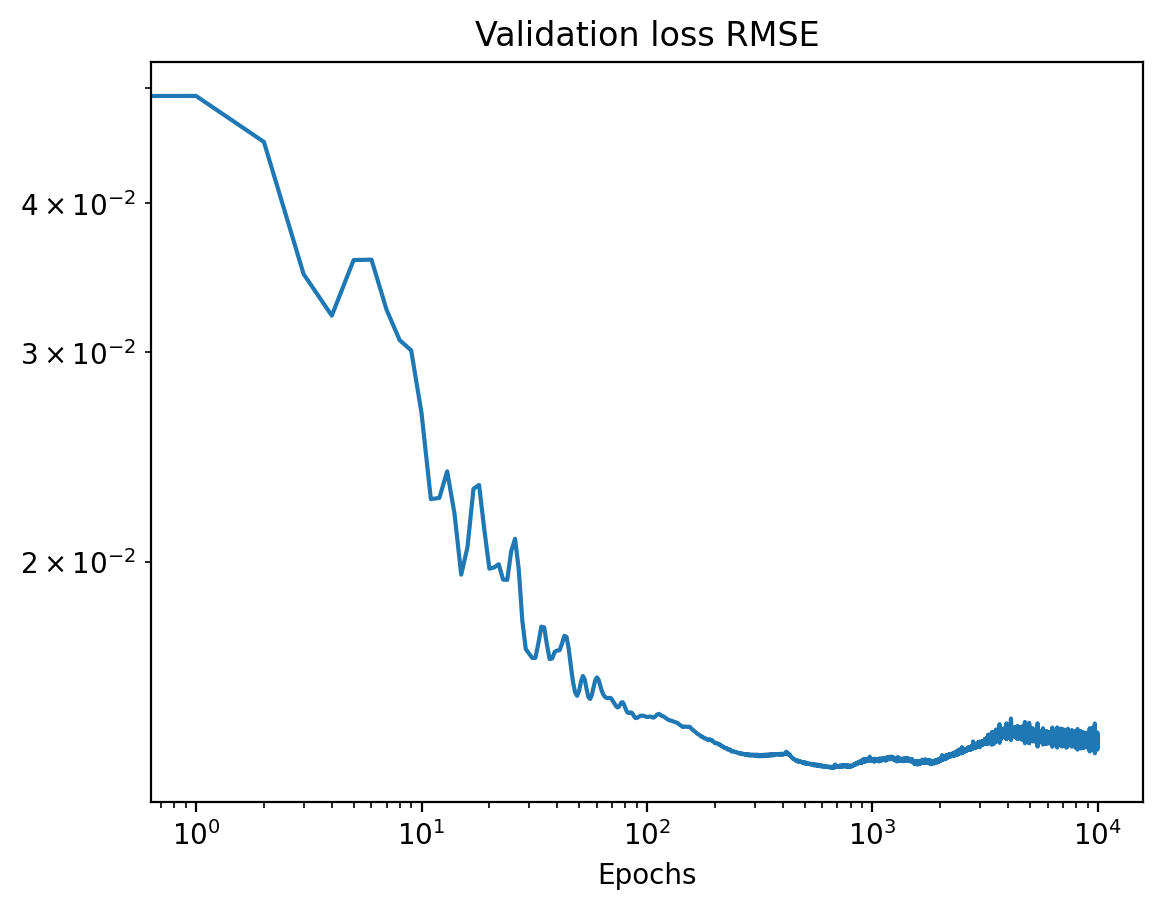

Saving model MLP
Time step 13
RMSE 0.012568220136377201, number of epochs 10000


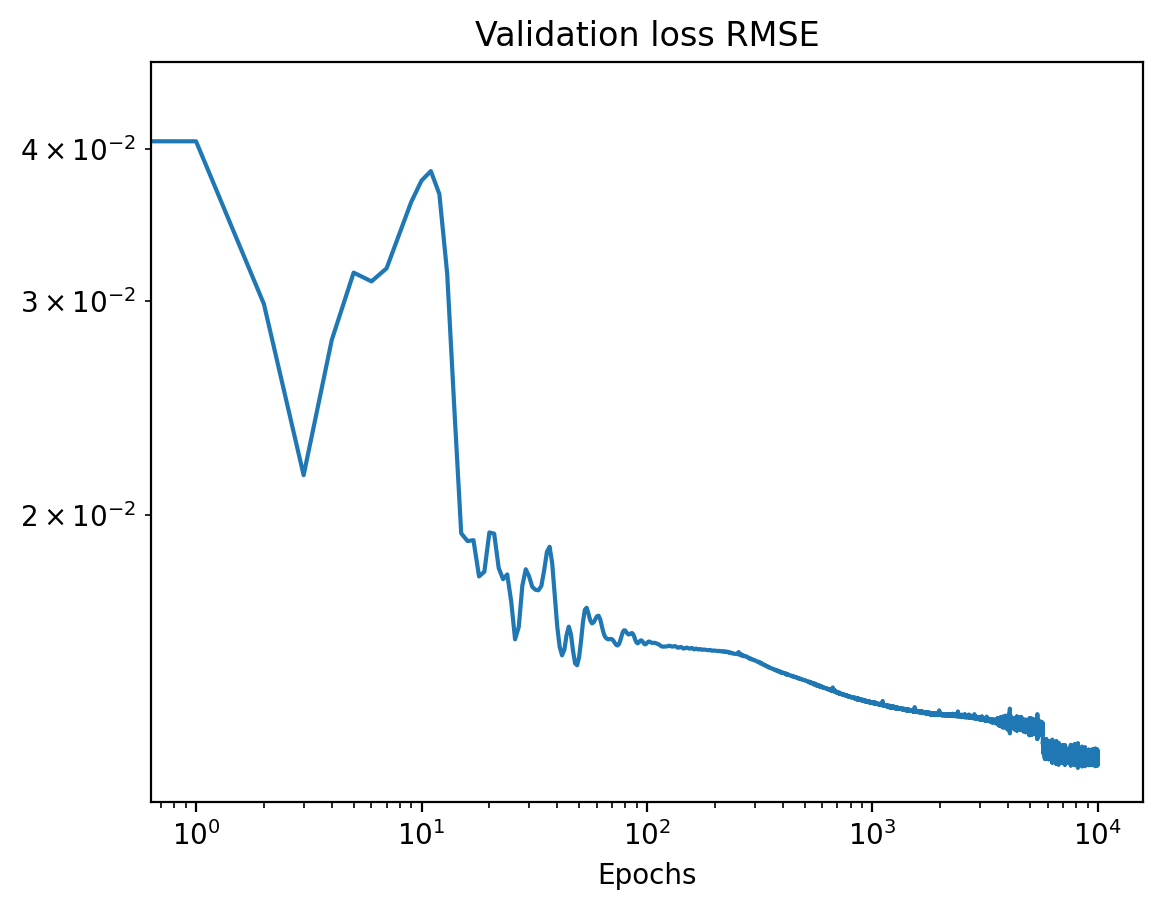

Saving model MLP
Time step 14
RMSE 0.0059840655165866, number of epochs 10000


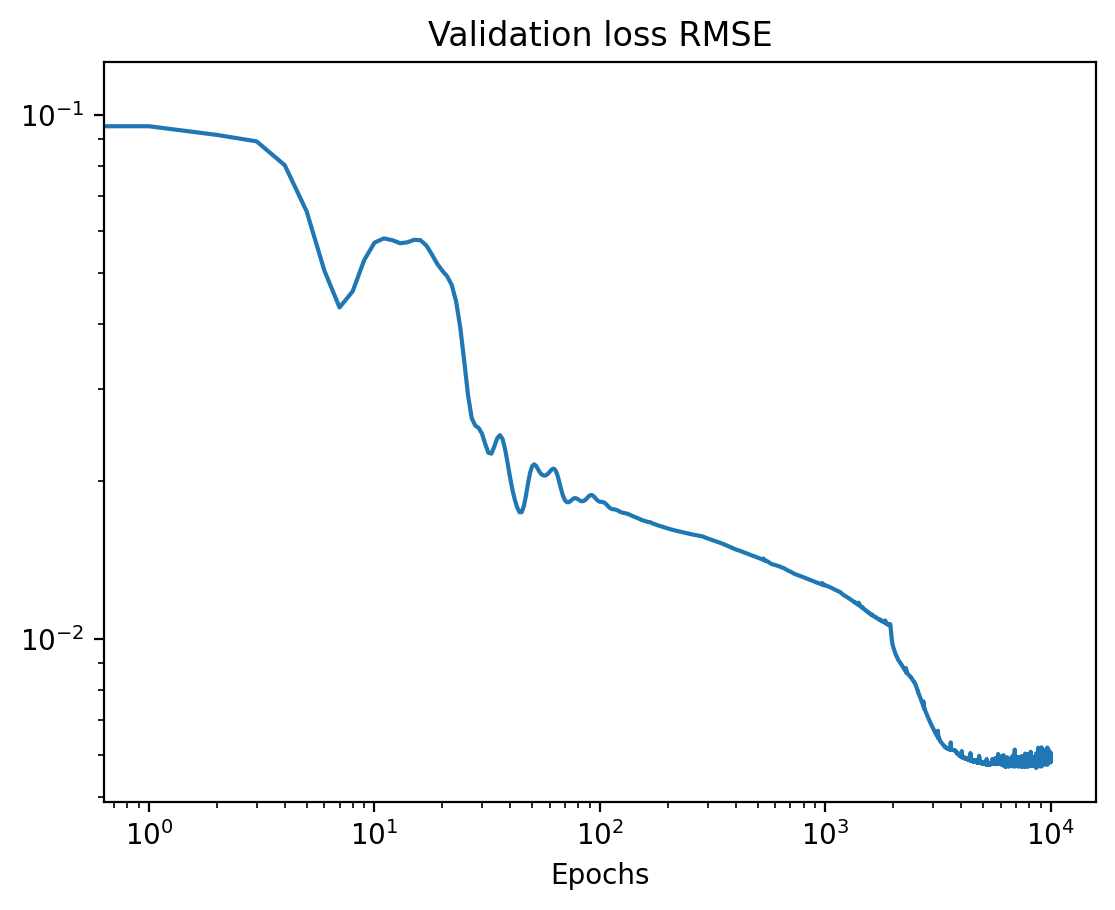

Saving model MLP
Time step 15
RMSE 0.002279931234061807, number of epochs 10000


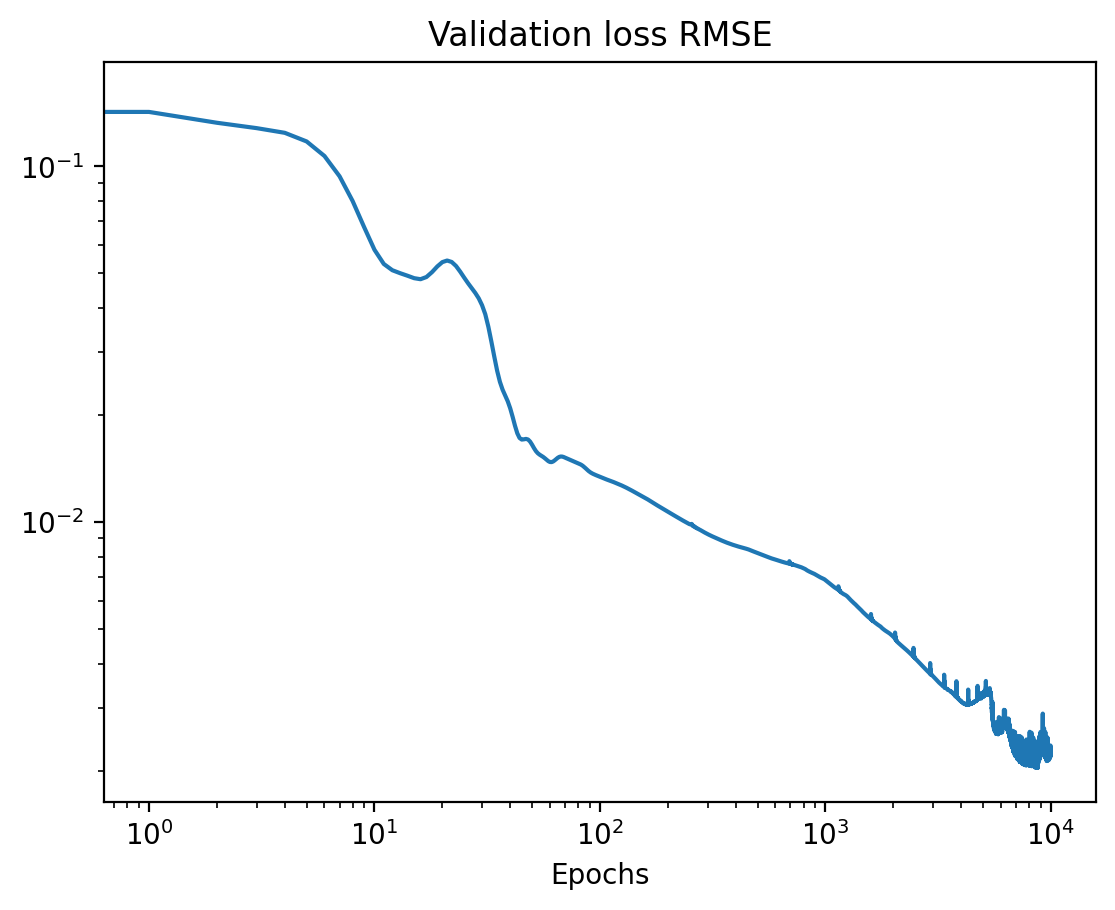

Saving model MLP
Time step 16
RMSE 0.0020819416880965944, number of epochs 10000


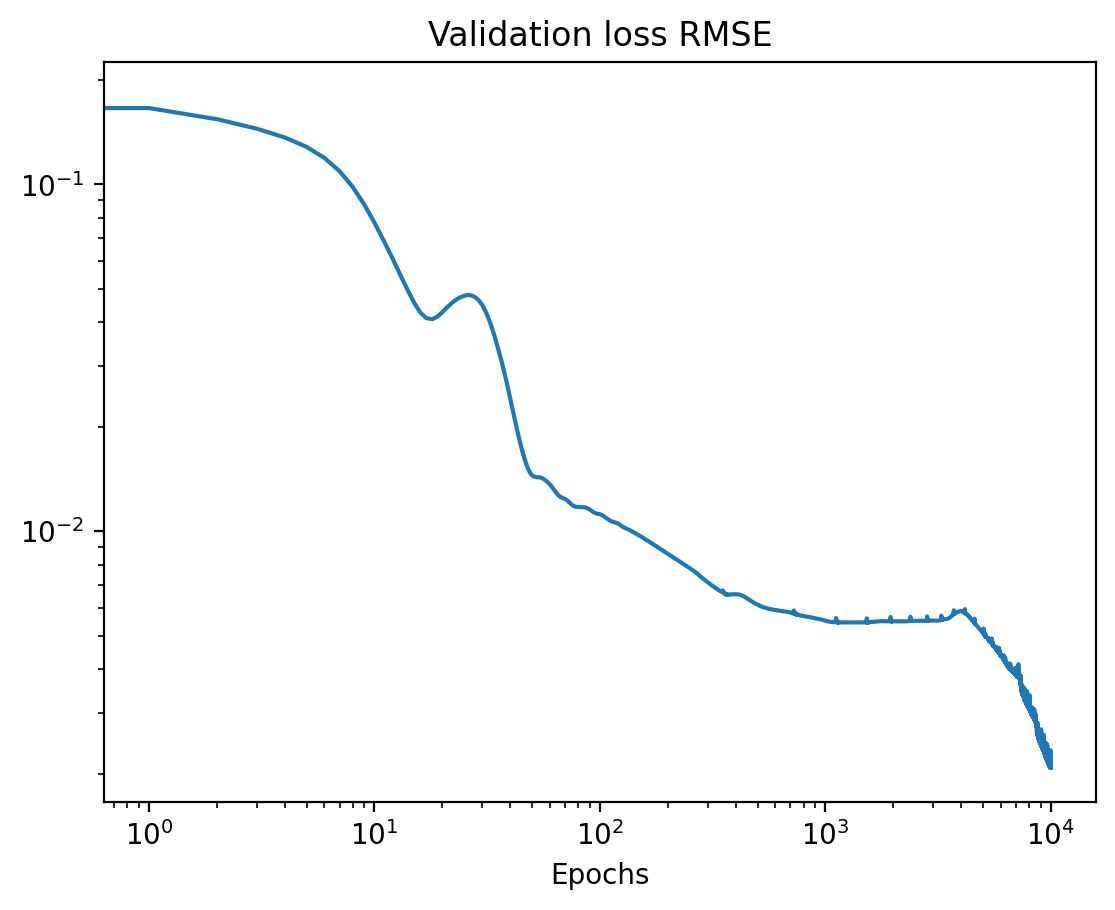

Saving model MLP
Time step 17
RMSE 0.002156111210460188, number of epochs 10000


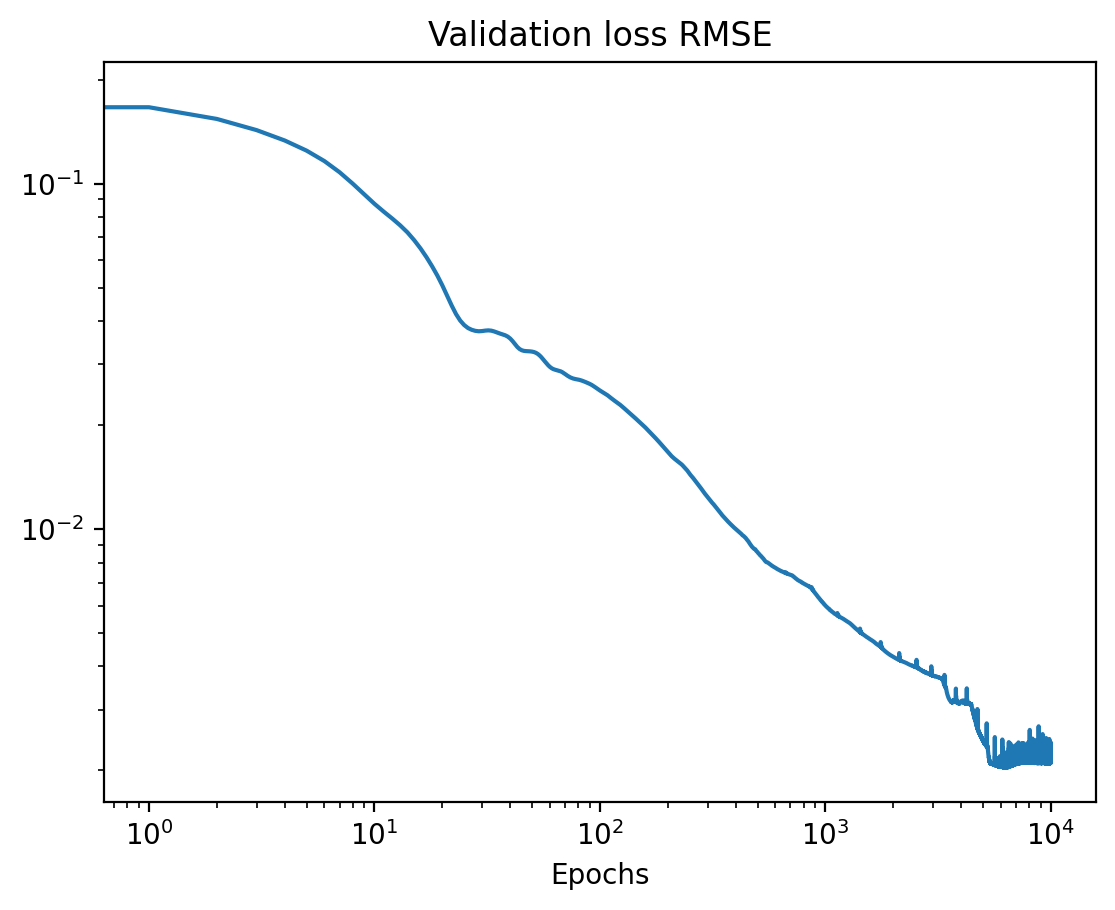

Saving model MLP
Time step 18
RMSE 0.00437233817003242, number of epochs 10000


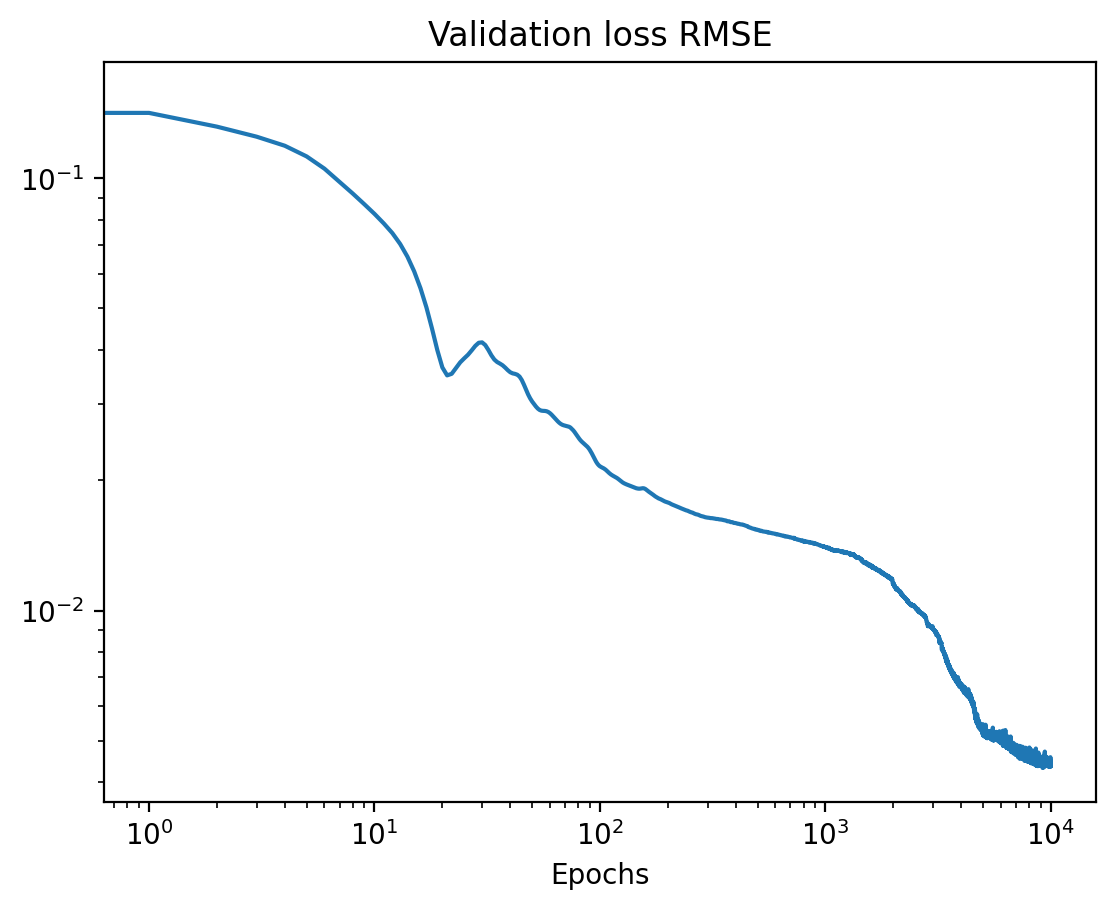

Saving model MLP
Time step 19
RMSE 0.010018707658267175, number of epochs 10000


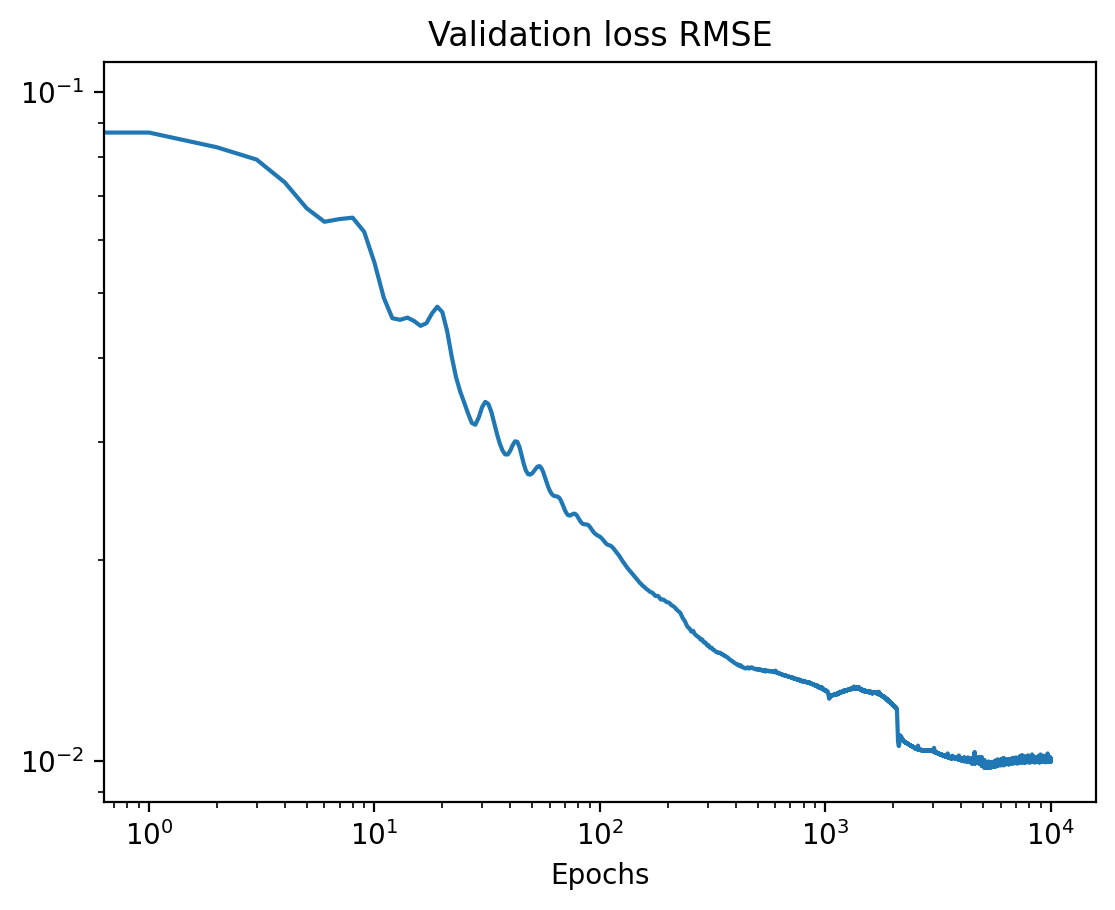

Saving model MLP
Time step 20
RMSE 0.008787811905747846, number of epochs 10000


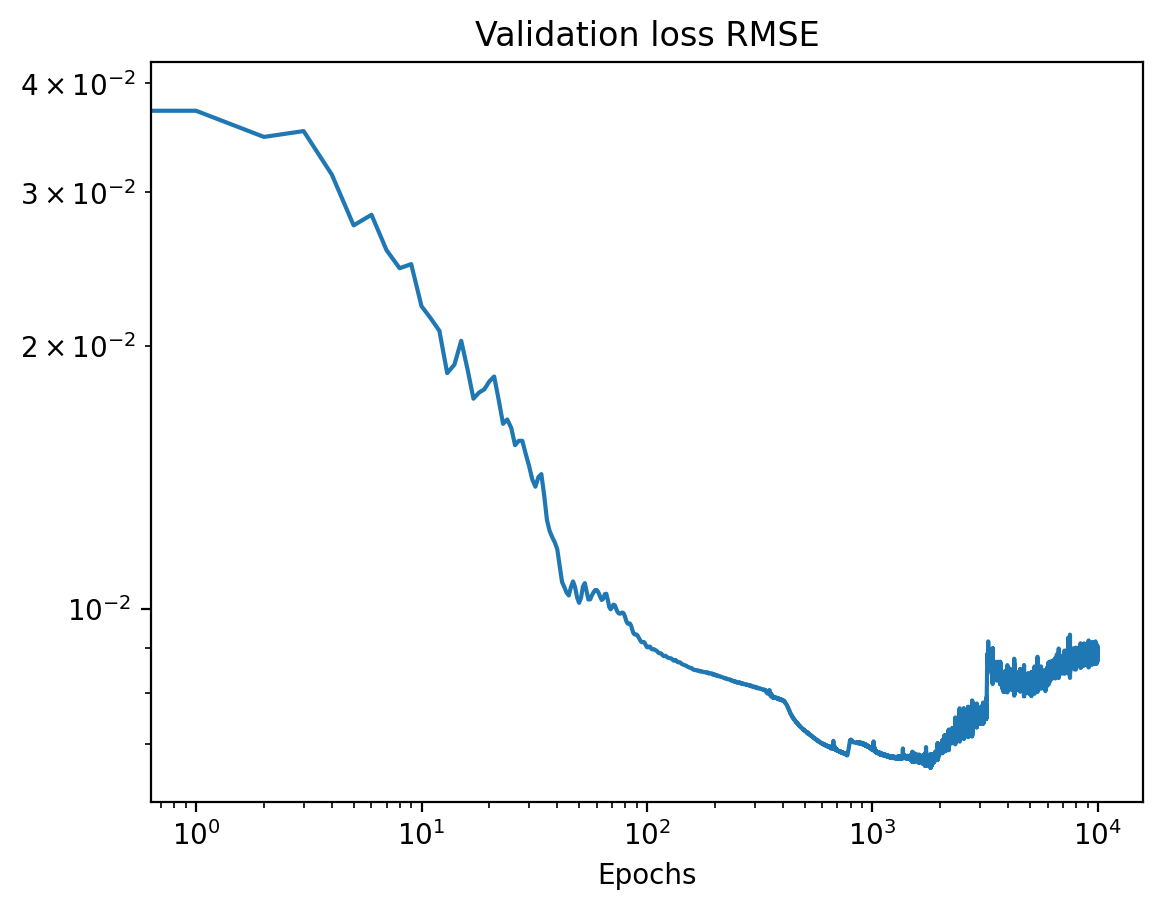

Saving model MLP
End time reached.
12:19:16 mma120347 SmartSim[424529:JobManager] INFO of_model(424752): SmartSimStatus.STATUS_COMPLETED


In [1]:
#!/usr/bin/python3

# Parsing OpenFOAM configuration files
from PyFoam.RunDictionary.ParsedParameterFile import ParsedParameterFile
import os
import sys
import pandas as pd

# SmartSim
from smartsim import Experiment
from smartredis import Client

from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams["figure.dpi"] = 200

import torch
import torch.nn as nn
import numpy as np
import io
from sklearn.model_selection import train_test_split
import torch.optim as optim 

from sklearn.metrics import mean_squared_error

# For calling pre-processing scripts
import subprocess

class MLP(nn.Module):
    def __init__(self, num_layers, layer_width, input_size, output_size, activation_fn):
        super(MLP, self).__init__()

        layers = []
        layers.append(nn.Linear(input_size, layer_width))
        layers.append(activation_fn)

        for _ in range(num_layers - 2):
            layers.append(nn.Linear(layer_width, layer_width))
            layers.append(activation_fn)

        layers.append(nn.Linear(layer_width, output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)
    
def sort_tensors_by_names(tensors, tensor_names):
    # Pair each tensor with its name and sort by the name
    pairs = sorted(zip(tensor_names, tensors))

    # Extract the sorted tensors
    tensor_names_sorted, tensors_sorted = zip(*pairs)

    # Convert back to list if needed
    tensor_names_sorted = list(tensor_names_sorted)
    tensors_sorted = list(tensors_sorted)

    return tensors_sorted, tensor_names_sorted

exp = Experiment("mesh-motion", launcher="local")

db = exp.create_database(port=8000,       # database port
                         interface="lo")  # network interface to use
exp.start(db)

# Connect the python client to the smartredis database
client = Client(address=db.get_address()[0], cluster=False)

# Read the number of mpi ranks from system/decomposePar dictionary
decompose_par = ParsedParameterFile("spinningDisk/system/decomposeParDict")
num_mpi_ranks = decompose_par['numberOfSubdomains']

of_rs = exp.create_run_settings(exe="moveDynamicMesh", exe_args="-parallel", 
                                run_command="mpirun", 
                                run_args={"np": f"{num_mpi_ranks}"})

of_model = exp.create_model(name="of_model", run_settings=of_rs)
of_model.attach_generator_files(to_copy="spinningDisk")

try:
    # Pre-process: clean existing data in spinningDisk.
    res_allrun_clean = subprocess.call(['bash', 'spinningDisk/Allclean'])
    print(f'Allrun.pre in spinningDisk executed with return code: {res_allrun_clean}')
    # Pre-process: create a mesh and decompose the solution domain of spinningDisk 
    # - Pre-processing does not interact with ML, so SmartSim models are not used.
    res_allrun_pre = subprocess.call(['bash', 'spinningDisk/Allrun.pre'])
    print(f'Allrun.pre in spinningDisk executed with return code: {res_allrun_pre}')
     
    # Run the experiment
    exp.generate(of_model, overwrite=True)
    exp.start(of_model, block=False)

    torch.set_default_dtype(torch.float64)

    # Initialize the model
    model = MLP(num_layers=2, layer_width=20, input_size=2, 
                output_size=2, activation_fn=torch.nn.ReLU())

    # Initialize the optimizer
    learning_rate = 1e-03
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Make sure all datasets are avaialble in the smartredis database.
    local_time_index = 1
    while True:

        print (f"Time step {local_time_index}")
          
        # Fetch datasets from SmartRedis
 
        # - Poll until the points datasets are written by OpenFOAM
        # print (f"dataset_list_length {dataset_list_length}") # Debug info
        points_updated = client.poll_list_length("pointsDatasetList", 
                                                 num_mpi_ranks, 10, 1000);
        if (not points_updated):
            raise ValueError("Points dataset list not updated.")
            
        # - Poll until the displacements datasets are written by OpenFOAM
        # print (f"dataset_list_length {dataset_list_length}") # Debug info
        displacements_updated = client.poll_list_length("displacementsDatasetList", 
                                                         num_mpi_ranks, 10, 1000);
        if (not displacements_updated):
            raise ValueError("Displacements dataset list not updated.")
            
        # - Get the points and displacements datasets from SmartRedis
        points_datasets = client.get_datasets_from_list("pointsDatasetList")  
        displacements_datasets = client.get_datasets_from_list("displacementsDatasetList")
        
        # - Agglomerate all tensors from points and displacements datasets: 
        #   sort tensors by their names to ensure matching patches of same MPI ranks
        points = []
        points_names = []
        displacements = []
        displacements_names = []

        # Agglomerate boudary points and displacements for training.
        # TODO(TM): for mesh motion, send points_MPI_r, displacements_MPI_r and 
        #           train the MLP directly on the tensors, there is no need to 
        #           differentiate the BCs, as values are used for the training. 
        for points_dset, displs_dset in zip(points_datasets, displacements_datasets):
            points_tensor_names = points_dset.get_tensor_names()
            displs_tensor_names = displs_dset.get_tensor_names()
            for points_name,displs_name in zip(points_tensor_names,displs_tensor_names):
                patch_points = points_dset.get_tensor(points_name)
                points.append(patch_points)
                points_names.append(points_name)

                patch_displs = displs_dset.get_tensor(displs_name)
                displacements.append(patch_displs)
                displacements_names.append(displs_name)
                
        points, points_names = sort_tensors_by_names(points, points_names)
        displacements, displacements_names = sort_tensors_by_names(displacements, displacements_names)
        
        # - Reshape points and displacements into [N_POINTS,SPATIAL_DIMENSION] tensors
        #   This basically agglomerates data from OpenFOAM boundary patches into a list
        #   of boundary points (unstructured) and a list of respective point displacements. 
        points = torch.from_numpy(np.vstack(points))
        displacements = torch.from_numpy(np.vstack(displacements))
        
        # TODO(TM): hardcoded x,y coordinates, make the OF client store polymesh::solutionD
        #           and use solutionD non-zero values for sampling vector coordinates. 
        points = points[:, :2]
        displacements = displacements[:, :2]

        # Split training and validation data
        points_train, points_val, displ_train, displ_val = train_test_split(points, displacements, 
                                                                            test_size=0.2, random_state=42)

        # PYTORCH Training Loop
        loss_func = nn.MSELoss()
        epochs = 10000
        mean_mag_displ = torch.mean(torch.norm(displ_train, dim=1))
        validation_rmse = []
        model.train()
        n_epochs = 0
        for epoch in range(epochs): 
            
            
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass on the training data
            displ_pred = model(points_train)

            # Compute loss on the training data
            loss_train = loss_func(displ_pred, displ_train)

            # Backward pass and optimization
            loss_train.backward()
            optimizer.step()

            # Forward pass on the validation data, with torch.no_grad() for efficiency
            with torch.no_grad():
                displ_pred_val = model(points_val)
                mse_loss_val = loss_func(displ_pred_val, displ_val)
                rmse_loss_val = torch.sqrt(mse_loss_val)
                validation_rmse.append(rmse_loss_val)
                if (rmse_loss_val < 1e-03):
                    break

            n_epochs = n_epochs + 1

        print (f"RMSE {validation_rmse[-1]}, number of epochs {n_epochs}")
        
        # Visualize validation RMSE
        plt.loglog()
        plt.title("Validation loss RMSE")
        plt.xlabel("Epochs")
        plt.plot(validation_rmse)
        plt.show()

        # Store the model into SmartRedis
        model.eval() # TEST
        # Prepare a sample input
        example_forward_input = torch.rand(2)
        # Convert the PyTorch model to TorchScript
        model_script = torch.jit.trace(model, example_forward_input)
        # Save the TorchScript model to a buffer
        model_buffer = io.BytesIO()
        torch.jit.save(model_script, model_buffer)
        # Set the model in the SmartRedis database
        print("Saving model MLP")
        client.set_model("MLP", model_buffer.getvalue(), "TORCH", "CPU")

        # Update the model in smartredis
        client.put_tensor("model_updated", np.array([0.]))

        # Delete dataset lists for the next time step
        client.delete_list("pointsDatasetList")
        client.delete_list("displacementsDatasetList")

        # Update time index
        local_time_index = local_time_index + 1

        if client.poll_key("end_time_index", 10, 10):
            print ("End time reached.")
            break
    
except Exception as e:
    print("Caught an exception: ", str(e))
    
finally:
    exp.stop(db)